# Deep Q Learning to Play Space Invaders

In [1]:
# Import packages
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random
import time

from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import backend as K

from skimage import transform 
from skimage.color import rgb2gray 

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9869075183280017981
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9848212736849024087
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## [1] Create the environment

In [4]:
# Create our environment
env = gym.make("SpaceInvaders-v0")

# Get state and action space
state_size = env.observation_space
action_size = env.action_space.n

print("The size of our frame is: ", state_size)
print("The action size is : ", action_size)

The size of our frame is:  Box(210, 160, 3)
The action size is :  6


## [2] Preprocess Functions

In [5]:
# plotting the images in a list
def plot_frames(display_list, title_list = None):
    
    plt.figure(figsize=(10, 10))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1) 
        
        if title_list:
            plt.title(title_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')

    plt.show()

### [2.1] Image Filtering

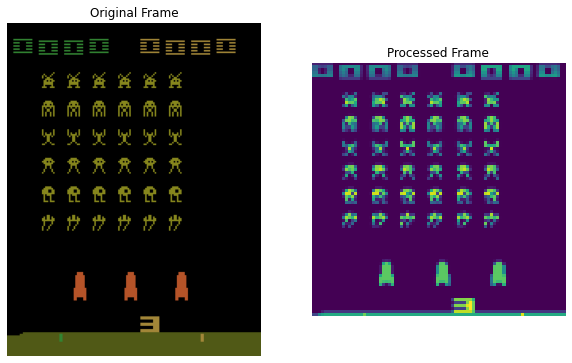

Size before process:  (210, 160, 3)
Size after process:  (84, 84)


In [6]:
# Normalise, turn into greyscale and crop image
frame_size = (84, 84)
def preprocess_frame(frame):
    # Greyscale frame 
    gray = rgb2gray(frame)
    
    # Crop the screen (remove the part below the player)
    # [Up: Down, Left: right]
    cropped_frame = gray[8:-12,4:-12]
    
    # Normalize Pixel Values
    normalized_frame = cropped_frame/255.0
    
    # Resize
    # Thanks to Mikołaj Walkowiak
    preprocessed_frame = transform.resize(normalized_frame, frame_size)
    
    return preprocessed_frame # 110x84x1 frame

# Test out the preprocess procedure
sample_state = env.reset()
sample_state_processed = preprocess_frame(sample_state)
plot_frames([sample_state, sample_state_processed], ['Original Frame','Processed Frame'])

print('Size before process: ', sample_state.shape)
print('Size after process: ', sample_state_processed.shape)

### [2.2] Stack the frames

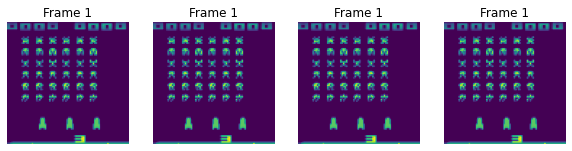

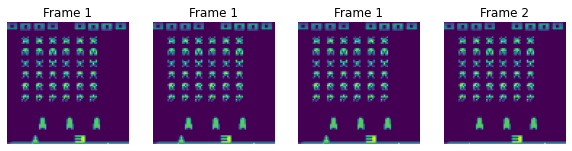

In [7]:
# Given a stacked frame, append a new frame to this stack
def stack_frames(stacked_frames, new_frame, is_new_episode):
    
    # Preprocess frame before stacking
    frame = preprocess_frame(new_frame)
    
    # if new episode make copies of frame, else append frame
    if is_new_episode:
        
        # Clear stacked frames
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        
        # Append the same frame to the stack stack_size times
        for _ in range(0, stack_size):
            stacked_frames.append(frame)
        
        # Return a numpy array for the stacked frame
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    else:
        stacked_frames.append(frame)
        stacked_states = np.stack(stacked_frames, axis = 2)
    
    return stacked_states, stacked_frames

# Stacking frames to provide input = [frame 1, frame 2, frame 3, frame 4]
stack_size = 4

# Initialise with array of zeros
stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)

# Test out the stack_frames procedure
sample_state = env.reset()
stacked_states, stacked_frames = stack_frames(stacked_frames, sample_state, True)
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(0,4)])

for i in range(0, 4):
    sample_next_state, _ , done , _  = env.step(env.action_space.sample())
    stacked_states, stacked_frames = stack_frames(stacked_frames, sample_next_state, False)
    
plot_frames(stacked_frames, ['Frame ' + str(1) for i in range(1,4)] + ['Frame 2'] )

## 3 Training 

In [8]:
# Define paramters for training 
LEARNING_RATE = 0.001
MEMORY_SIZE = 50000
BATCH_SIZE = 64
MAX_STEP = 50000
UPDATE_MODEL_STEP = 5000

EXPLORATION_RATE = 1
EXPLORATION_DECAY = 0.9999
EXPLORATION_MIN = 0.01

GAMMA = 0.9

### [3.1] Create Deep Q Neural Network

In [9]:
def Create_Q_Network(use_duel = True):
    
    # Create base model
    input_layer = tf.keras.Input(shape = (84, 84, 4))
    conv1 = tf.keras.layers.Conv2D(32, kernel_size = [8, 8], strides = [4,4], activation='relu')(input_layer)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size = [4, 4], strides = [2,2], activation='relu')(conv1)
    conv3 = tf.keras.layers.Conv2D(64, kernel_size = [3, 3], strides = [2,2], activation='relu')(conv2)
    flatten = tf.keras.layers.Flatten()(conv3)
    
    # Create advantage stream
    if useDuel:
        fc1 = tf.keras.layers.Dense(512)(flatten)
        advantage = tf.keras.layers.Dense(action_size)(fc1)
        advantage = tf.keras.layers.Lambda(lambda a: a[:, :] - K.mean(a[:, :], axis=1, keepdims=True), output_shape=(action_size,))(advantage)

        # create value stream
        fc2 = tf.keras.layers.Dense(512)(flatten)
        value = tf.keras.layers.Dense(1)(fc2)
        value = tf.keras.layers.Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_size,))(value)

        # Output the Q values
        output = tf.keras.layers.Add()([value, advantage])
    else:
        dense = tf.keras.layers.Dense(512)(flatten)
        output = tf.keras.layers.Dense(action_size)(dense)

    # Compile model
    model = tf.keras.Model(inputs=input_layer, outputs=[output])
    model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(lr=LEARNING_RATE))
    
    return model

In [10]:
# Create the DQN and Target DQN
use_duel = True
DQNetwork = Create_Q_Network(use_duel)
TargetDQNewtork = Create_Q_Network(use_duel)

DQNetwork.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   8224        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 64)     32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

### [3.2] Create memory for experience relay

In [13]:
class SumTree:
    
    # Index for pointing to data 
    data_index = 0
    capacity_filled = 0
    
    # Initialise the tree and data
    def __init__(self, capacity):
        
        # The size of the leaves
        self.capacity = capacity
        
        # Define the tree list itself, zeros everywhere
        self.tree = np.zeros(capacity*2 - 1)
        
        # Define the data list for holding experiences, zeros everywhere
        self.data = np.zeros(capacity, dtype=object)
        
    # Add new values to tree
    def add(self, priority, data):
        
        # add to data list 
        self.data[self.data_index] = data
        
        # add the priority to the leaf of the tree
        tree_index = self.data_index + self.capacity - 1
        self.update(priority, tree_index)
        
        # Increase data_index
        self.data_index += 1
        if self.data_index > self.capacity - 1:
            self.data_index = 0
            
        # Inrease capacity filled
        if self.capacity_filled < self.capacity:
            self.capacity_filled += 1
            
    # Update all the nodes leading up to a leaf
    def update(self, priority, tree_index):
        
        # Find the change in priority value
        delta_priority = priority - self.tree[tree_index]
        
        # Update leaf
        self.tree[tree_index] = priority
        
        # Propagate change up
        while tree_index != 0 :
            tree_index = (tree_index - 1)//2
            self.tree[tree_index] += delta_priority 
            
    # sample a leaf from a value
    def get_leaf(self, value):
        
        # Define initial indixes
        parent_index = 0
        left_index = 1
        right_index = 2
        
        # Retrive the leaf algorithm
        while left_index < (2*self.capacity - 1):
            if self.tree[left_index] >= value: 
                parent_index = left_index
            else:
                parent_index = right_index
                value = value - self.tree[left_index]      
            # Update left_index for next iteration
            left_index = parent_index*2 + 1
            right_index = left_index + 1
            
        return parent_index, self.tree[parent_index], self.data[parent_index + 1 - self.capacity]

In [14]:
class Memory():
    
    # Max TD error
    abs_error_upper = 1.0;
    
    # Prioritzation exponents
    PER_a = 0.6
    PER_b = 0.4
    epsilon= 0.01
    
    # Incremental value for PER_b
    PER_b_increments = 0.001
    
    def __init__(self, capacity):
        
        # Create the sum tree
        self.memory_tree = SumTree(capacity)
            
    def store(self, experience):
        
        # Get the max priority so far
        max_priority = np.max(self.memory_tree.tree[-self.memory_tree.capacity:])
        
        # if max prioity is 0 then set it as abs_error_upper
        if max_priority == 0:
            max_priority = self.abs_error_upper
        
        # Store this experience in the tree
        self.memory_tree.add(max_priority, experience)
        
        
    def sample(self, n):
        
        # Get total priority
        total_priority = self.memory_tree.tree[0]
        
        # Sample from a mini range [0:total_priority] in batch sizes
        sample_ranges = np.linspace(0, total_priority, num=n+1)
        
        # get min P(i) of data filled so far and max weight to scale maximum weights = 1
        start_filled = -self.memory_tree.capacity
        end_filled = -(self.memory_tree.capacity - self.memory_tree.capacity_filled)
        if  end_filled == 0:
            min_probability = np.min(self.memory_tree.tree[start_filled:])/total_priority
        else:
            min_probability = np.min(self.memory_tree.tree[start_filled:end_filled])/total_priority
        max_weight = (self.memory_tree.capacity_filled * min_probability) ** (-self.PER_b)
        
        # Initialise list for storing
        tree_indexes = np.empty(n, dtype=np.int32)
        IS_weights = np.empty(n, dtype=np.float32)
        batch = []
        
        # Sample in a loop
        for i in range(0, n):
            value = np.random.uniform(sample_ranges[i], sample_ranges[i+1])
            tree_index, priority, experience = self.memory_tree.get_leaf(value)
            
            # Append tree indicies of sample 
            tree_indexes[i] = tree_index
            
            # Obtain IS_weights
            sample_probability = (priority / total_priority)
            IS_weights[i] = ((self.memory_tree.capacity_filled * sample_probability) ** (-self.PER_b)) / max_weight
            
            # append expereice  to batch
            batch.append(experience)
            
        # Increase PER_b value for every sampling action max = 1
        if self.PER_b < 1.0:
            self.PER_b += self.PER_b_increments
        
        return tree_indexes, IS_weights, batch
            
            
    def update_batch(self, tree_indexes, TD_errors):
        priorities = np.minimum(self.abs_error_upper, (TD_errors + self.epsilon)) ** self.PER_a
        
        # update the batch of prrioties
        for idx, new_p in zip(tree_indexes, priorities):
            self.memory_tree.update(new_p, idx)

In [11]:
# Create a memery storage 
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
        
    def store(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

### [3.3] Act to exploit or explore

In [12]:
# Function to pick action either from model or take random action
def act(state, exploration_rate):
    
    # Take random action
    if np.random.rand() < exploration_rate:
        return env.action_space.sample()
    
    # Else use the model to predict a action
    q_values = DQNetwork.predict(state[tf.newaxis,...])
    
    return np.argmax(q_values[0])

### [3.5] Test agent by taking random actions

In [13]:
# Play a game to test environment 
def test(n_episodes, model = None, memory = None):
    
    # Initialise average rewards
    avg_rewards = 0
    run_list = []
    
    for i in range(1, n_episodes+1):
        
        # Initialise the start of environment
        state = env.reset()
        stacked_frames = deque([np.zeros(frame_size, dtype = np.int) for i in range(0,stack_size)], maxlen=stack_size)
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        done = False 
        total_reward = 0
        steps = 0

        while not done:
            if model:
                action = np.argmax(model.predict(state[tf.newaxis,...])[0])
            else:
                action = env.action_space.sample()
            state_next, reward, done, info = env.step(action)
            state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)
            if memory:
                memory.store((state, action, reward, state_next, done))
            state = state_next
            total_reward += reward
            steps += 1
            if steps > MAX_STEP:
                done = True
        
        avg_rewards = avg_rewards + 1/(i) * (total_reward - avg_rewards)
        run_list.append(steps)
        
    return run_list, avg_rewards

## [3.4] Train agent in batches from memory

In [18]:
def model_train(BATCH_SIZE):

     # Sample from batch
    tree_idx, IS_weights, batch = memory.sample(BATCH_SIZE)

    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, 84, 84, 4))
    action_batch = np.zeros(BATCH_SIZE, dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, 84, 84, 4))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i] = batch[i][1]
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Get predicted Q values
    target_Q_batch = DQNetwork.predict(state_batch)
    Q_state_old = np.array(target_Q_batch)
    Q_next_state = DQNetwork.predict(state_next_batch)
    Target_Q_next_state = TargetDQNewtork.predict(state_next_batch)
    
    # For debugging
    best_acts = []
    # Calculate target Q
    for i in range(0,len(batch)):
        if done_batch[i]:
            target_Q_batch[i][action_batch[i]] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            best_acts.append(best_action)
            target_Q_batch[i][action_batch[i]] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]


    # Update the sum tree priority values based on new absolute errors
    indices = np.arange(BATCH_SIZE, dtype=np.int32)
    abs_TD_error = np.abs(Q_state_old[indices, np.array(action_batch)]-target_Q_batch[indices, np.array(action_batch)])
    memory.update_batch(tree_idx, abs_TD_error)     

    history = DQNetwork.fit(state_batch, target_Q_batch, batch_size=BATCH_SIZE, sample_weight=IS_weights,  verbose = 0)
    
    return history, sum(target_Q_batch[indices, np.array(action_batch)]),  best_acts # For debugging

In [14]:
def model_train(BATCH_SIZE):

     # Sample from batch
    batch = memory.sample(BATCH_SIZE)

    # Extract each parameter from batch
    state_batch = np.zeros((BATCH_SIZE, 84, 84, 4))
    action_batch = np.zeros(BATCH_SIZE, dtype = int)
    reward_batch = np.zeros(BATCH_SIZE)
    state_next_batch = np.zeros((BATCH_SIZE, 84, 84, 4))
    done_batch = np.zeros(BATCH_SIZE)
    for i in range(0,len(batch)):
        state_batch[i] = batch[i][0]
        action_batch[i] = batch[i][1]
        reward_batch[i] = batch[i][2]
        state_next_batch[i] = batch[i][3]
        done_batch[i] = batch[i][4]

    # Get predicted Q values
    target_Q_batch = DQNetwork.predict(state_batch)
    Q_state_old = np.array(target_Q_batch)
    Q_next_state = DQNetwork.predict(state_next_batch)
    Target_Q_next_state = TargetDQNewtork.predict(state_next_batch)
    
    # For debugging
    best_acts = []
    # Calculate target Q
    for i in range(0,len(batch)):
        if done_batch[i]:
            target_Q_batch[i][action_batch[i]] = reward_batch[i]
        else:
            best_action = np.argmax(Q_next_state[i])
            best_acts.append(best_action)
            target_Q_batch[i][action_batch[i]] = reward_batch[i] + GAMMA * Target_Q_next_state[i][best_action]


    # Update the sum tree priority values based on new absolute errors
    indices = np.arange(BATCH_SIZE, dtype=np.int32)

    history = DQNetwork.fit(state_batch, target_Q_batch, batch_size=BATCH_SIZE,  verbose = 0)
    
    return history, sum(target_Q_batch[indices, np.array(action_batch)]),  best_acts # For debugging

In [15]:
def update_model():
    TargetDQNewtork.set_weights(DQNetwork.get_weights())

In [42]:
# Check time taken to train for 1 batch
start_time = time.time()
history = model_train(BATCH_SIZE)
print("Loss is :", history.history['loss'][0])
print("Elapsed_time: ", time.time() - start_time)

Loss is : 0.0010642644483596087
Elapsed_time:  0.18639516830444336


In [16]:
# DO a DQN and TargetDQN Test before training
steps, total_reward = test(1, model = DQNetwork, memory = None)
print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)

steps, total_reward = test(1, model = TargetDQNewtork, memory = None)
print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)

Total steps by taking random actions:  [929]
Total rewards by taking random actions:  85.0
Total steps by taking random actions:  [937]
Total rewards by taking random actions:  245.0


In [17]:
# Test if both models are the same
print(DQNetwork(stacked_states[tf.newaxis,...]))
print(TargetDQNewtork(stacked_states[tf.newaxis,...]))

tf.Tensor(
[[-5.4486736e-05 -2.7833306e-05  1.9832926e-04 -2.6265864e-04
   5.1507781e-05 -5.7771300e-05]], shape=(1, 6), dtype=float32)
tf.Tensor(
[[-9.8864170e-05  3.2419437e-05  5.7971862e-05  2.1456581e-04
   1.4763488e-04  4.2296695e-05]], shape=(1, 6), dtype=float32)


In [18]:
update_model()
# Test if both models are the same
print(DQNetwork(stacked_states[tf.newaxis,...]))
print(TargetDQNewtork(stacked_states[tf.newaxis,...]))

tf.Tensor(
[[-5.4486736e-05 -2.7833306e-05  1.9832926e-04 -2.6265864e-04
   5.1507781e-05 -5.7771300e-05]], shape=(1, 6), dtype=float32)
tf.Tensor(
[[-5.4486736e-05 -2.7833306e-05  1.9832926e-04 -2.6265864e-04
   5.1507781e-05 -5.7771300e-05]], shape=(1, 6), dtype=float32)


### Training on the environment

In [ ]:
# path for saving
path =  "./D3QN_PER_KerasModels/model.h5"

# Re-Initialise memory for training
memory = Memory(MEMORY_SIZE)

# Store measurements
loss = []
reward_list = []
step_list = []
total_steps = 0
start_time = time.time()

# For debugging
acts = []
Test1 = []
Test2 = []
target_tests = []
best_act_tests = []

 # Number of episodes to train 
N = 12  
for i in range(0, N):

    # Initialise state
    state = env.reset()
    state, stacked_frames = stack_frames(stacked_frames, state, True)
    reward_sum = 0
    
    # Initialise step oer episode
    step = 0
    done = False
    
    while not done:
        
        # Get action 
        action = act(state, EXPLORATION_RATE)
        #acts.append(np.argmax(DQNetwork.predict(state[tf.newaxis,...])))  # For debugging
        
        # Take action
        state_next, reward, done, _ = env.step(action)
        
        # stops the episode by set max step
        if step > MAX_STEP:
            done = True
            print("Episode Done")

        # Append the next state
        state_next, stacked_frames = stack_frames(stacked_frames, state_next, False)

        # Append to memory
        memory.store((state, action, reward, state_next, done))

        # Forward to next state
        state = state_next
        
        # accumulate rewards
        reward_sum += reward
        
        # Update model every UPDATE_STEP (5000)
        if total_steps % UPDATE_MODEL_STEP == 0:
            update_model()
            print("Target network updated!")
        
        # accumilate steps
        step += 1
        total_steps += 1

        # Reduce the exploreation every step
        EXPLORATION_RATE *= EXPLORATION_DECAY
        EXPLORATION_RATE = max(EXPLORATION_MIN, EXPLORATION_RATE)
        
        ### Learning procedure begins ###
        # learn only when memory has be filled to batch size
#         if memory.memory_tree.capacity_filled >= BATCH_SIZE:
#             history, target_test, best_act_test = model_train(BATCH_SIZE) # For debugging
         
        if len(memory.buffer) >= BATCH_SIZE:
            history, target_test, best_act_test = model_train(BATCH_SIZE) # For debugging
            
            # store loss
            loss.append(history.history['loss'])
            target_tests.append(target_test)
            best_act_tests.append(best_act_test)
            
        ### Learning procedure ends ###

        # Print messge 
#         if total_steps % 100 == 0:
#             print("Afte {} steps, exploration rate: {:.4f}, reward: {}, Model loss: {:.4f}, Time elapsed: {:.4f}"\
#                   .format(total_steps, EXPLORATION_RATE, reward_sum, history.history['loss'][0], time.time() - start_time))
#             start_time = time.time()
            
    # Append values at the end of an episode
    step_list.append(step)
    reward_list.append(reward_sum)
    

    ### DO A TEST at the end of each episode of traind ~~~~~~~~~~ 
    # For debugging
    _, reward_test_DQN = test(1, model = DQNetwork, memory = None)
    _, reward_test_TargetDQN = test(1, model = TargetDQNewtork, memory = None)
    Test1.append(reward_test_DQN)
    Test2.append(reward_test_TargetDQN)
    print(reward_test_DQN, DQNetwork(stacked_states[tf.newaxis,...]))
    print(reward_test_TargetDQN, TargetDQNewtork(stacked_states[tf.newaxis,...]))
    
    # print information at the end of the episode
    print("Episode {}, exploration rate: {:.4f}, final rewards: {}, final loss is {:.4f}, Time elapsed: {:.4f}"\
          .format(i+1, EXPLORATION_RATE, reward_sum, history.history['loss'][0], time.time() - start_time))
    start_time = time.time()
    
# path for saving
path =  './D3QN_PER_Keras_model/model.h5'
DQNetwork.save(path) 

Target network updated!


In [20]:
# DO a DQN and TargetDQN Test before training    # For debugging
steps, total_reward = test(1, model = DQNetwork, memory = None)
print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)

steps, total_reward = test(1, model = TargetDQNewtork, memory = None)
print("Total steps by taking random actions: ", steps)
print("Total rewards by taking random actions: ", total_reward)

Total steps by taking random actions:  [1709]
Total rewards by taking random actions:  695.0
Total steps by taking random actions:  [680]
Total rewards by taking random actions:  105.0


In [21]:
# Test if both models are the same    # For debugging
print(np.argmax(DQNetwork(stacked_states[tf.newaxis,...])))
print(np.argmax(TargetDQNewtork(stacked_states[tf.newaxis,...])))

1
4


[50.0, 40.0, 65.0, 110.0, 80.0, 60.0, 50.0, 135.0, 120.0]


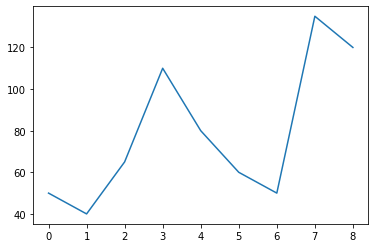

In [22]:
plt.plot(Test1)    # For debugging reward for each episode DQN
print(Test1)

[410.0, 80.0, 195.0, 110.0, 265.0, 410.0, 125.0, 150.0, 45.0]


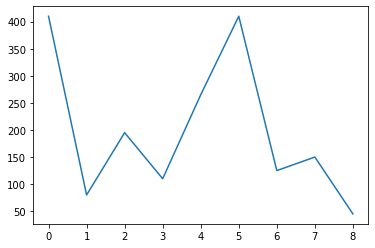

In [23]:
plt.plot(Test2)    # For debugging reward for each episode TargetDQN
print(Test2)

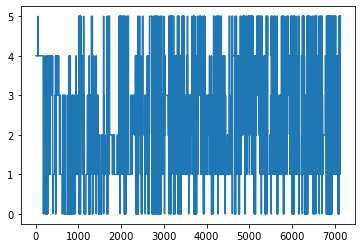

In [25]:
plt.plot(acts)     # For debugging

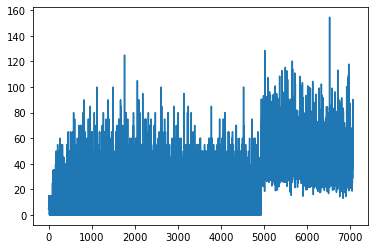

In [27]:
plt.plot(target_tests)  # For debugging

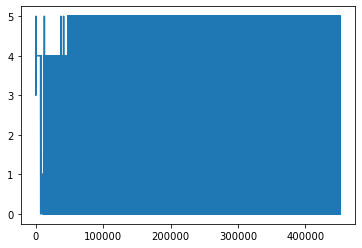

In [26]:
flat_list = [item for sublist in best_act_tests for item in sublist]
plt.plot(flat_list)

In [102]:
# path for saving
path =  './D3QN_PER_Keras_model/model.h5'
DQNetwork.save(path) 

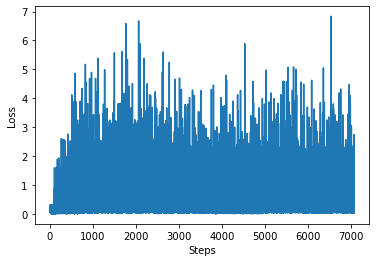

In [28]:
# plot loss
plt.plot(loss)
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.show()

In [108]:
# Number of steps learnt
print(memory.memory_tree.capacity_filled)

4140


In [34]:
# simulate a result play a game and render
# loaded_model = tf.keras.models.load_model(path)

state = env.reset()
state, stacked_frames = stack_frames(stacked_frames, state, True)

done = False 
total_reward = 0
steps = 0
act = []

# until done 
while not done:
    
    # render the current environment 
    env.render()

    # take an action using model
    action = np.argmax(TargetDQNewtork.predict(state[tf.newaxis,...]))
    act.append(action)
    next_state, reward, done, info = env.step(action)
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    state = next_state
    
    total_reward += reward
    steps += 1

env.close()
print ("Score: {}, Steps: {}".format(total_reward, steps))

Score: 145.0, Steps: 988


In [40]:
env.close()

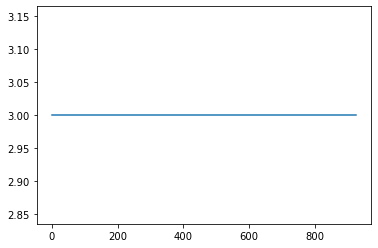

In [120]:
plt.plot(act)

In [110]:
DQNetwork.predict(state[tf.newaxis,...])

array([[0.3997964 , 0.5197129 , 0.58153725, 0.74430275, 0.6561715 ,
        0.41897172]], dtype=float32)

In [111]:
TargetDQNewtork.predict(state[tf.newaxis,...])

array([[0.5153854 , 0.4144917 , 0.26997602, 0.31328744, 0.35302752,
        0.24757175]], dtype=float32)